<a href="https://colab.research.google.com/github/eghib22/Store-Sales-Forecasting/blob/main/model_experiment_N-Beats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ekaterineghibradze","key":"b1414052fbae86987efff2083c8dcbd1"}'}

In [8]:
!mv "kaggle.json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!ls -l ~/.kaggle/

total 4
-rw------- 1 root root 74 Jul  6 11:19 kaggle.json


In [10]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 916MB/s]


In [11]:
! unzip walmart-recruiting-store-sales-forecasting

Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [12]:
!unzip '*.csv.zip'

Archive:  test.csv.zip
  inflating: test.csv                

Archive:  features.csv.zip
  inflating: features.csv            

Archive:  sampleSubmission.csv.zip
  inflating: sampleSubmission.csv    

Archive:  train.csv.zip
  inflating: train.csv               

4 archives were successfully processed.


In [13]:
!unzip '*.csv.zip'

Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                

Archive:  features.csv.zip
replace features.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: features.csv            

Archive:  sampleSubmission.csv.zip
replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sampleSubmission.csv    

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               

4 archives were successfully processed.


In [14]:
import pandas as pd

# Load the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')
sample_submission = pd.read_csv('sampleSubmission.csv')

# Explore the data
print("Train shape:", train.shape)
print(train.head())
print(train.columns)

print("\nTest shape:", test.shape)
print(test.head())
print(test.columns)

print("\nFeatures shape:", features.shape)
print(features.head())
print(features.columns)

print("\nStores shape:", stores.shape)
print(stores.head())
print(stores.columns)

print("\nSample Submission shape:", sample_submission.shape)
print(sample_submission.head())
print(sample_submission.columns)

Train shape: (421570, 5)
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False
Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')

Test shape: (115064, 4)
   Store  Dept        Date  IsHoliday
0      1     1  2012-11-02      False
1      1     1  2012-11-09      False
2      1     1  2012-11-16      False
3      1     1  2012-11-23       True
4      1     1  2012-11-30      False
Index(['Store', 'Dept', 'Date', 'IsHoliday'], dtype='object')

Features shape: (8190, 12)
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        3

In [15]:
# Merge train and test with features and stores
train_merged = pd.merge(train, features, on=['Store', 'Date'], how='left')
train_merged = pd.merge(train_merged, stores, on='Store', how='left')

test_merged = pd.merge(test, features, on=['Store', 'Date'], how='left')
test_merged = pd.merge(test_merged, stores, on='Store', how='left')

# Convert Date to datetime
train_merged['Date'] = pd.to_datetime(train_merged['Date'])


In [16]:
# Split
train_data = train_merged[train_merged['Date'] < '2012-01-01']
val_data = train_merged[(train_merged['Date'] >= '2012-01-01') & (train_merged['Date'] < '2012-07-01')]
test_data = train_merged[train_merged['Date'] >= '2012-07-01']

print("Train:", train_data.shape)
print("Validation:", val_data.shape)
print("Test (local):", test_data.shape)

Train: (294132, 17)
Validation: (77110, 17)
Test (local): (50328, 17)


In [17]:
def preprocess(df):
    df = df.copy()

    # Map Type A/B/C to 0/1/2
    type_map = {'A': 0, 'B': 1, 'C': 2}
    df['Type'] = df['Type'].map(type_map)

    # Ensure IsHoliday is int (True/False → 1/0)
    if 'IsHoliday_x' in df.columns:
        df['IsHoliday'] = df['IsHoliday_x'].astype(int)
        df = df.drop(columns=['IsHoliday_x', 'IsHoliday_y'])
    elif 'IsHoliday' in df.columns:
        df['IsHoliday'] = df['IsHoliday'].astype(int)

    # Fill NaNs in MarkDown columns with 0
    markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
    for col in markdown_cols:
        if col in df.columns:
            df[col] = df[col].fillna(0)

    # Extract date features
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
    df['Day'] = df['Date'].dt.day

    return df


Preparing data for N-BEATS model...
Feature columns: ['Store', 'Dept', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'IsHoliday', 'Year', 'Month', 'Week', 'Day', 'DayOfWeek', 'DayOfYear']
Number of features: 20
Data types in train_processed:
Store             int64
Dept              int64
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
Type              int64
Size              int64
IsHoliday         int64
Year              int64
Month             int64
Week              int64
Day               int64
DayOfWeek         int64
DayOfYear         int64
dtype: object
Creating sequences with 20 features: ['Store', 'Dept', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type

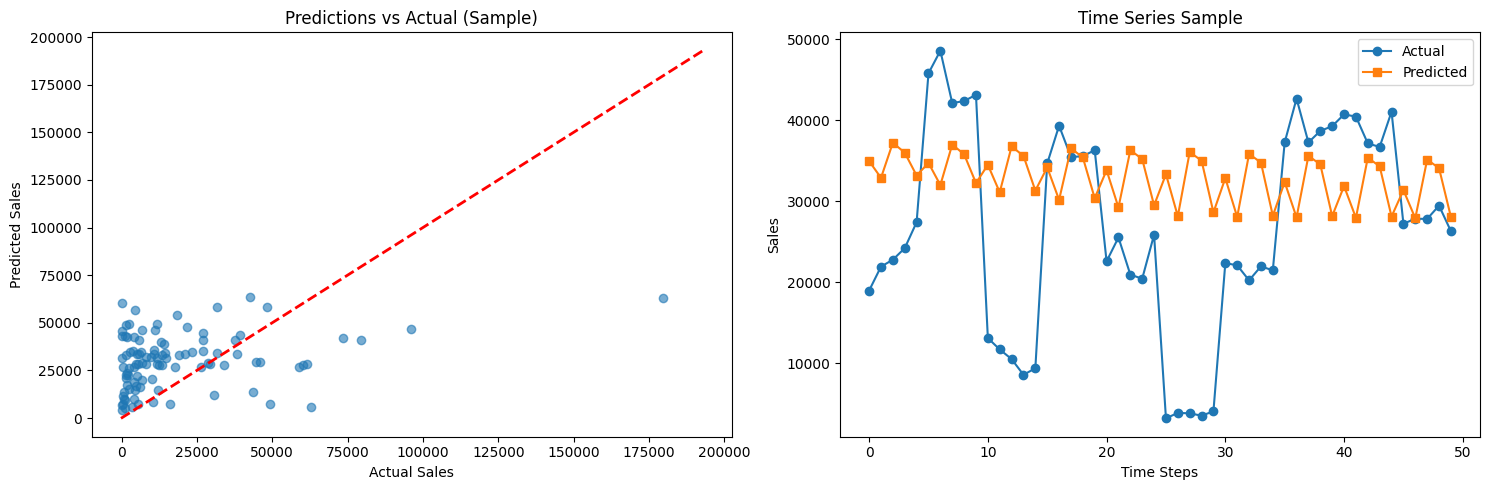

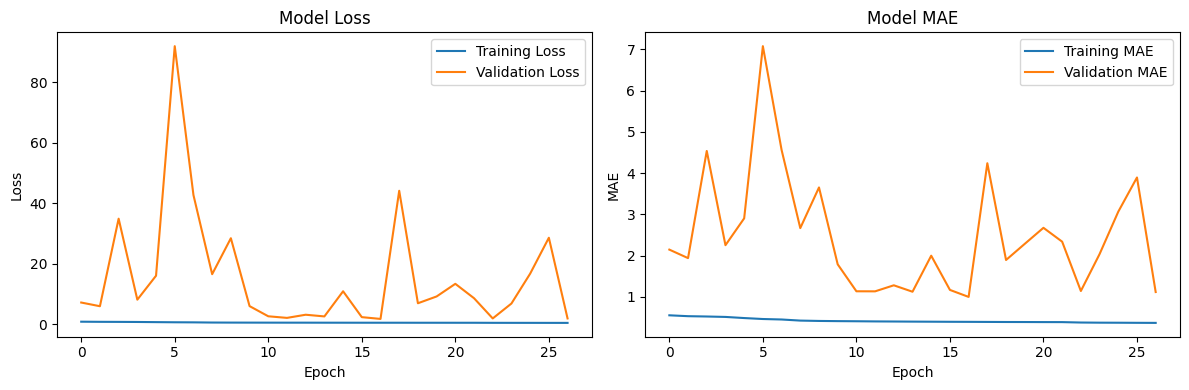


Final Results:
Test MAE: 21264.00
Test WMAE: 21264.00
Test WMAE (Holiday weighted): 20127.07


In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class NBeatsBlock(layers.Layer):
    """N-BEATS block implementation"""

    def __init__(self, units, thetas_dim, horizon, backcast_length, share_weights=False, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.thetas_dim = thetas_dim
        self.horizon = horizon
        self.backcast_length = backcast_length
        self.share_weights = share_weights

        # Fully connected layers
        self.fc1 = layers.Dense(units, activation='relu')
        self.fc2 = layers.Dense(units, activation='relu')
        self.fc3 = layers.Dense(units, activation='relu')
        self.fc4 = layers.Dense(units, activation='relu')

        # Theta layers
        self.theta_f = layers.Dense(thetas_dim, activation='linear')
        self.theta_b = layers.Dense(thetas_dim, activation='linear')

        # Basis functions (simplified - using linear basis)
        self.basis_f = layers.Dense(horizon, activation='linear')
        self.basis_b = layers.Dense(backcast_length, activation='linear')

    def call(self, inputs):
        # Forward pass through FC layers
        x = self.fc1(inputs)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        # Generate thetas
        theta_f = self.theta_f(x)
        theta_b = self.theta_b(x)

        # Generate forecast and backcast
        forecast = self.basis_f(theta_f)
        backcast = self.basis_b(theta_b)

        return forecast, backcast

class NBeatsModel(keras.Model):
    """N-BEATS model implementation"""

    def __init__(self, horizon, backcast_length, num_blocks=3, units=256, thetas_dim=8, **kwargs):
        super().__init__(**kwargs)
        self.horizon = horizon
        self.backcast_length = backcast_length
        self.num_blocks = num_blocks

        # Create N-BEATS blocks
        self.blocks = []
        for i in range(num_blocks):
            block = NBeatsBlock(
                units=units,
                thetas_dim=thetas_dim,
                horizon=horizon,
                backcast_length=backcast_length,
                name=f'nbeats_block_{i}'
            )
            self.blocks.append(block)

    def call(self, inputs):
        # Initialize forecasts and residuals
        forecasts = []
        residual = inputs

        # Pass through each block
        for block in self.blocks:
            forecast, backcast = block(residual)
            forecasts.append(forecast)
            residual = residual - backcast

        # Sum all forecasts
        total_forecast = tf.reduce_sum(forecasts, axis=0)
        return total_forecast

def preprocess(df):
    """Preprocess the data"""
    # Encode categorical type
    type_map = {'A': 0, 'B': 1, 'C': 2}
    df = df.copy()  # Avoid SettingWithCopyWarning

    # Handle Type column
    if 'Type' in df.columns:
        df['Type'] = df['Type'].map(type_map)
        df['Type'] = df['Type'].fillna(0)  # Fill any NaN with 0

    # Handle IsHoliday columns
    if 'IsHoliday_x' in df.columns:
        df['IsHoliday'] = df['IsHoliday_x'].astype(int)
        df = df.drop(columns=['IsHoliday_x', 'IsHoliday_y'])
    elif 'IsHoliday' in df.columns:
        df['IsHoliday'] = df['IsHoliday'].astype(int)

    # Date features (before dropping Date)
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df['Year'] = df['Date'].dt.year.astype(int)
        df['Month'] = df['Date'].dt.month.astype(int)
        df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
        df['Day'] = df['Date'].dt.day.astype(int)
        df['DayOfWeek'] = df['Date'].dt.dayofweek.astype(int)
        df['DayOfYear'] = df['Date'].dt.dayofyear.astype(int)

        # Drop Date column after extracting features
        df = df.drop(columns=['Date'])

    # Fill MarkDown NaNs
    markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
    for col in markdown_cols:
        if col in df.columns:
            df[col] = df[col].fillna(0.0)

    # Ensure all numeric columns are proper numeric types
    numeric_cols = ['Store', 'Dept', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

def create_sequences(data, lookback, horizon, target_col='Weekly_Sales'):
    """Create sequences for time series forecasting"""
    sequences = []
    targets = []

    # Ensure we have the right columns
    if target_col not in data.columns:
        raise ValueError(f"Target column '{target_col}' not found in data")

    # Get feature columns (excluding target)
    feature_cols = [col for col in data.columns if col != target_col]

    print(f"Creating sequences with {len(feature_cols)} features: {feature_cols}")

    # Group by Store and Dept to maintain temporal order
    for (store, dept), group in data.groupby(['Store', 'Dept']):
        # Reset index to ensure continuous indexing
        group = group.reset_index(drop=True)

        if len(group) < lookback + horizon:
            continue

        # Create sequences for this store-dept combination
        for i in range(len(group) - lookback - horizon + 1):
            # Input sequence (features only)
            seq_features = group.iloc[i:i+lookback][feature_cols].values

            # Target sequence
            target_seq = group.iloc[i+lookback:i+lookback+horizon][target_col].values

            # Ensure correct shape
            if seq_features.shape[0] == lookback and len(target_seq) == horizon:
                sequences.append(seq_features)
                targets.append(target_seq)

    sequences = np.array(sequences, dtype=np.float32)
    targets = np.array(targets, dtype=np.float32)

    print(f"Created {len(sequences)} sequences with shape: {sequences.shape}")
    print(f"Target shape: {targets.shape}")

    return sequences, targets

def create_walmart_nbeats_model(input_shape, horizon=1, num_blocks=3, units=256):
    """Create N-BEATS model for Walmart sales forecasting"""

    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Flatten the input for N-BEATS
    flattened = layers.Flatten()(inputs)

    # Add some preprocessing layers
    x = layers.Dense(512, activation='relu')(flattened)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    # N-BEATS blocks
    forecasts = []
    residual = x

    for i in range(num_blocks):
        # FC layers for this block
        block_out = layers.Dense(units, activation='relu')(residual)
        block_out = layers.Dense(units, activation='relu')(block_out)
        block_out = layers.Dense(units, activation='relu')(block_out)

        # Forecast and backcast
        forecast = layers.Dense(horizon, activation='linear', name=f'forecast_{i}')(block_out)
        backcast = layers.Dense(residual.shape[-1], activation='linear')(block_out)

        forecasts.append(forecast)
        residual = layers.Subtract()([residual, backcast])

    # Sum all forecasts
    if len(forecasts) > 1:
        output = layers.Add()(forecasts)
    else:
        output = forecasts[0]

    model = keras.Model(inputs=inputs, outputs=output)
    return model

def calculate_wmae(y_true, y_pred, weights=None):
    """Calculate Weighted Mean Absolute Error"""
    if weights is None:
        weights = np.ones_like(y_true)

    # Ensure arrays are flattened
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    weights = weights.flatten()

    # Calculate weighted MAE
    mae = np.abs(y_true - y_pred)
    wmae = np.sum(weights * mae) / np.sum(weights)

    return wmae

def prepare_walmart_data(train_data, val_data, test_data, lookback=12, horizon=1):
    """Prepare data for N-BEATS model"""

    # Preprocess all datasets
    train_processed = preprocess(train_data.copy())
    val_processed = preprocess(val_data.copy())
    test_processed = preprocess(test_data.copy())

    # Get feature columns (excluding target and any remaining non-numeric columns)
    feature_cols = [col for col in train_processed.columns
                   if col not in ['Weekly_Sales', 'Date'] and
                   train_processed[col].dtype in ['int64', 'float64', 'int32', 'float32']]

    print(f"Feature columns: {feature_cols}")
    print(f"Number of features: {len(feature_cols)}")

    # Debug: Check data types
    print("Data types in train_processed:")
    print(train_processed[feature_cols].dtypes)

    # Scale features (excluding target)
    scaler_features = StandardScaler()
    scaler_target = StandardScaler()

    # Fit scalers on training data
    train_features = train_processed[feature_cols].astype(np.float32)
    train_target = train_processed['Weekly_Sales'].values.reshape(-1, 1).astype(np.float32)

    scaler_features.fit(train_features)
    scaler_target.fit(train_target)

    # Transform all datasets
    train_processed[feature_cols] = scaler_features.transform(train_features)
    train_processed['Weekly_Sales'] = scaler_target.transform(train_target).flatten()

    val_features = val_processed[feature_cols].astype(np.float32)
    val_target = val_processed['Weekly_Sales'].values.reshape(-1, 1).astype(np.float32)
    val_processed[feature_cols] = scaler_features.transform(val_features)
    val_processed['Weekly_Sales'] = scaler_target.transform(val_target).flatten()

    test_features = test_processed[feature_cols].astype(np.float32)
    test_target = test_processed['Weekly_Sales'].values.reshape(-1, 1).astype(np.float32)
    test_processed[feature_cols] = scaler_features.transform(test_features)
    test_processed['Weekly_Sales'] = scaler_target.transform(test_target).flatten()

    # Create sequences
    X_train, y_train = create_sequences(train_processed, lookback, horizon)
    X_val, y_val = create_sequences(val_processed, lookback, horizon)
    X_test, y_test = create_sequences(test_processed, lookback, horizon)

    # Ensure correct data types
    X_train = X_train.astype(np.float32)
    y_train = y_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    y_val = y_val.astype(np.float32)
    X_test = X_test.astype(np.float32)
    y_test = y_test.astype(np.float32)

    print(f"Training sequences: {X_train.shape}, {y_train.shape}")
    print(f"Validation sequences: {X_val.shape}, {y_val.shape}")
    print(f"Test sequences: {X_test.shape}, {y_test.shape}")
    print(f"Data types - X_train: {X_train.dtype}, y_train: {y_train.dtype}")

    return (X_train, y_train, X_val, y_val, X_test, y_test,
            scaler_features, scaler_target)

def train_nbeats_model(X_train, y_train, X_val, y_val,
                      epochs=100, batch_size=64, learning_rate=0.001):
    """Train N-BEATS model"""

    # Create model
    model = create_walmart_nbeats_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        horizon=y_train.shape[1],
        num_blocks=3,
        units=256
    )

    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )

    # Callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
    ]

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

def evaluate_model(model, X_test, y_test, scaler_target):
    """Evaluate model and calculate WMAE"""

    # Make predictions
    y_pred_scaled = model.predict(X_test)

    # Inverse transform predictions and targets
    y_pred = scaler_target.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_true = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()

    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    wmae = calculate_wmae(y_true, y_pred)

    # Calculate WMAE with holiday weights (higher weight for holiday periods)
    # This is a simplified version - in practice, you'd use the exact Walmart competition weights
    holiday_weights = np.where(y_true > np.median(y_true), 5, 1)  # Higher weight for higher sales
    wmae_weighted = calculate_wmae(y_true, y_pred, holiday_weights)

    print(f"Test MAE: {mae:.2f}")
    print(f"Test WMAE: {wmae:.2f}")
    print(f"Test WMAE (Holiday weighted): {wmae_weighted:.2f}")

    return y_pred, y_true, mae, wmae, wmae_weighted

def plot_predictions(y_true, y_pred, n_samples=100):
    """Plot predictions vs actual values"""
    plt.figure(figsize=(15, 5))

    # Plot sample predictions
    plt.subplot(1, 2, 1)
    sample_idx = np.random.choice(len(y_true), min(n_samples, len(y_true)), replace=False)
    plt.scatter(y_true[sample_idx], y_pred[sample_idx], alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Sales')
    plt.ylabel('Predicted Sales')
    plt.title('Predictions vs Actual (Sample)')

    # Plot time series sample
    plt.subplot(1, 2, 2)
    sample_range = slice(0, min(50, len(y_true)))
    plt.plot(y_true[sample_range], label='Actual', marker='o')
    plt.plot(y_pred[sample_range], label='Predicted', marker='s')
    plt.xlabel('Time Steps')
    plt.ylabel('Sales')
    plt.title('Time Series Sample')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Assuming you have already loaded and preprocessed your data
    # train_data, val_data, test_data should be available

    print("Preparing data for N-BEATS model...")
    (X_train, y_train, X_val, y_val, X_test, y_test,
     scaler_features, scaler_target) = prepare_walmart_data(
        train_data, val_data, test_data,
        lookback=12, horizon=1
    )

    print("\nTraining N-BEATS model...")
    model, history = train_nbeats_model(
        X_train, y_train, X_val, y_val,
        epochs=50, batch_size=32, learning_rate=0.001
    )

    print("\nEvaluating model...")
    y_pred, y_true, mae, wmae, wmae_weighted = evaluate_model(
        model, X_test, y_test, scaler_target
    )

    print("\nPlotting results...")
    plot_predictions(y_true, y_pred)

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"\nFinal Results:")
    print(f"Test MAE: {mae:.2f}")
    print(f"Test WMAE: {wmae:.2f}")
    print(f"Test WMAE (Holiday weighted): {wmae_weighted:.2f}")